In [1]:
import optuna
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


from sklearn.model_selection import GridSearchCV, cross_val_score

import warnings
warnings.filterwarnings('ignore')

## Основные сведенья после ДЗ2
Стало ясно, что некоторые объекты (строки) в данных скоррелированы. Например, у нас есть несколько строк для одного клиента в разные месяцы, если мы сделаем случайное разбиение, часть данных о клиенте останется в train, часть уйдет в test. Даже если удалить идентификаторы клиентов, описание клиента за март и апрель могут оказать довольно похожи, если не одинаков, поэтому модель с большой долей вероятности может "запомнить", что она предсказала раньше для объекта с определенным признаковым описанием, и выдать это уже на тесте... Лучше в данном случае сделать как минимум разбиение с группировкой по Customer_ID - часть клиентов останется в train, другая, непересекающаяся с ней часть - в test. Проводить FE мы не будем, так как это только ухудшает результаты модели, поэтому сами данные получены до этого этапа.

In [2]:
df = pd.read_csv('data/prep_data_after_hw_2.csv')
df.head()

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Age_Months
0,CUS_0xd40,January,23,Scientist,19114.12,1824.843333,3,4,3,4,...,Unknown,810.0,26.822620,No,49.574949,80.415295,High_spent_Small_value_payments,312.5,Good,265
1,CUS_0xd40,February,23,Scientist,19114.12,1592.843333,3,4,3,4,...,Good,810.0,31.944960,No,49.574949,118.280222,Low_spent_Large_value_payments,284.8,Good,0
2,CUS_0xd40,April,23,Scientist,19114.12,1592.843333,3,4,3,4,...,Good,810.0,31.377862,No,49.574949,199.458074,Low_spent_Small_value_payments,223.5,Good,268
3,CUS_0xd40,May,23,Scientist,19114.12,1824.843333,3,4,3,4,...,Good,810.0,24.797347,No,49.574949,41.420153,High_spent_Medium_value_payments,341.5,Good,269
4,CUS_0xd40,July,23,Scientist,19114.12,1824.843333,3,4,3,4,...,Good,810.0,22.537593,No,49.574949,178.344067,Low_spent_Small_value_payments,244.6,Good,271


### Преобразуем категориальные признаки в числовые
1) Можно обратить внимание, что фичи <code>Credit_Mix</code>, <code>Payment_Behaviour</code> и целевая переменная<code>Credit_Score</code>  
обладают неким порядком, поэтому уместно использовать <code>Ordinal Encoding</code>.    
2) Для фичи <code>Occupation</code> лучше всего использовать <code>LeaveOneOut</code>, поскольку данная фича  
принимает 16 категорий и важно уменьшить утечку информации (кажется, что все encoder-ы типа Ohe не подойдут, так как они просто раздуют df, что для решающего дерева не совсем хороший вариант).
3) Для <code>Payment_of_Min_Amount</code> проблемой не будет использовать Ohe (всего классов два).
4) <code>Month</code> преобразуем через Oridinal Encoding,   
поскольку переменная содержит перечисление месяцев   
(на этапе обучение модели данная фича будет удалена,  
так как она нам нужна только для сортировки). 
5) <code>Customer_ID</code> будет преобразована с помощью   
LableEncoding, поскольку данная фича будет использоваться для группировки, но не для обучения.


In [3]:
ordinal_features = ['Credit_Score', 'Credit_Mix','Payment_Behaviour']
ordinal_encoder = OrdinalEncoder(categories=[['Poor','Standard','Good'],
                                             ['Unknown','Bad','Standard', 'Good'],
                                             ['Unknown',
                                              'Low_spent_Small_value_payments',
                                              'Low_spent_Medium_value_payments',
                                              'Low_spent_Large_value_payments',
                                              'High_spent_Small_value_payments',
                                              'High_spent_Medium_value_payments',
                                              'High_spent_Large_value_payments']  
                                            ])

leave_one_out_encoder = ce.LeaveOneOutEncoder(cols=['Occupation'])

month_order = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 
    'May': 5, 'June': 6, 'July': 7, 'August': 8, 
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}
label_encoder = LabelEncoder()

def category_encoder(df):
    df = df.copy()
    df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map({'Yes': 1, 'No': 0})
    df['Month'] = df['Month'].map(month_order)
    df['Customer_ID'] = label_encoder.fit_transform(df['Customer_ID'])
    df[ordinal_features] = ordinal_encoder.fit_transform(df[ordinal_features])
    df['Occupation'] = leave_one_out_encoder.fit_transform(df['Occupation'], df['Credit_Score'])
    
    return df


df = category_encoder(df)

In [4]:
df_train, df_test = train_test_split(df, test_size=0.7, stratify=df['Credit_Score'])

In [5]:
# возьмем в качестве нового df только часть от истенного df, 
# поскольку подбор гиперпараметров проходит довольно долго.

df = df_train

# Разобъем данные на train и test
Чтобы обучающие данные всегда предшествовали тестовым по времени,  
данные будут разбиты на два набора, где более ранние месяцы идут в обучение,   
а более поздние в тест. Для такой разбивки используем такой месяц как июнь.

In [6]:
# Сортируем данные по времени

df = df.sort_values(by=['Customer_ID', 'Month'])

train_data = df[df['Month'] <= 6] 
test_data = df[df['Month'] > 6]  

X_train = train_data.drop(columns=['Credit_Score', 'Customer_ID','Month'])
y_train = train_data['Credit_Score']
X_test = test_data.drop(columns=['Credit_Score', 'Customer_ID','Month'])
y_test = test_data['Credit_Score']

#  Оптимизация гиперпараметров
В качестве сложной модели возьмем RandomForestClassifier.  
Для всех методов оптимизации будем брать по 3 fold-a. Будем брать такие параметры:    
max_features=[sqrt, log2, None] ->  определяет сколько признаков модель будет случайным образом выбирать.  
max_depth=[10, 20, None] -> определяет максимальную глубину дерева.  
n_estimators=[50, 100] --> количество эстиматоров(деревьев)  
min_samples_leaf=[1, 2, 4] --> минимальное количество признаков в листе.  
min_samples_split=[2, 5, 10] --> определяет минимальное количество образцов, необходимых для разделения узла дерева.   
Возьмем scoring='f1_weighted', поскольку классы у нас несбалансированы
1) Используем GridSearchCV для подбора лучших гиперпараметров.
3) Используем Optuna для подбора лучших гиперпараметров.

In [7]:
# Используем GridSearchCV для подбора гиперпараметров
# Используем лучшие парметры для обучения с class_weight='balanced' для того,
# чтобы нивелировать дисбаланс классов.
# Измерение качества на отложенной выборке.

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=22, class_weight='balanced'),
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)
best_model_cv = grid_search.best_estimator_
print("Лучшие параметры:", grid_search.best_params_)

y_pred = best_model_cv.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Лучшие параметры: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80      1662
         1.0       0.81      0.81      0.81      3020
         2.0       0.65      0.71      0.68      1117

    accuracy                           0.78      5799
   macro avg       0.76      0.77      0.76      5799
weighted avg       0.79      0.78      0.78      5799



In [8]:
# Используем Optuna для подбора гиперпараметров

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 100, step=10),
        'max_depth': trial.suggest_int('max_depth', 10, 20, step=5),  
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 5, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 2, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2',None]),
    }
    model = RandomForestClassifier(**param, random_state=22, class_weight='balanced')
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction="maximize", study_name="RandomForest Optimization")
study.optimize(objective, n_trials=20)

[I 2024-11-30 22:23:12,277] A new study created in memory with name: RandomForest Optimization
[I 2024-11-30 22:23:18,831] Trial 0 finished with value: 0.7893733074287156 and parameters: {'n_estimators': 50, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.7893733074287156.
[I 2024-11-30 22:23:20,615] Trial 1 finished with value: 0.7137485595251785 and parameters: {'n_estimators': 80, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7893733074287156.
[I 2024-11-30 22:23:23,496] Trial 2 finished with value: 0.7309760620437055 and parameters: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7893733074287156.
[I 2024-11-30 22:23:30,210] Trial 3 finished with value: 0.7530012063571742 and parameters: {'n_estimators': 70, 'max_depth': 10, 'min_samples_split': 2, 'm

Лучшие параметры: {'n_estimators': 90, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80      1662
         1.0       0.80      0.82      0.81      3020
         2.0       0.65      0.69      0.67      1117

    accuracy                           0.78      5799
   macro avg       0.76      0.76      0.76      5799
weighted avg       0.78      0.78      0.78      5799



In [11]:
best_model_optuna = RandomForestClassifier(**study.best_params, random_state=22, class_weight='balanced')
best_model_optuna.fit(X_train, y_train)

y_pred = best_model_optuna.predict(X_test)

print("Лучшие параметры:", study.best_params)
print(classification_report(y_test, y_pred))

Лучшие параметры: {'n_estimators': 90, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80      1662
         1.0       0.80      0.82      0.81      3020
         2.0       0.65      0.69      0.67      1117

    accuracy                           0.78      5799
   macro avg       0.76      0.76      0.76      5799
weighted avg       0.78      0.78      0.78      5799



# Интерпритация модели
Для интерпретации модели используем метод Permutation Importance, который выделит важные признаки.

### Оценка важности признаков после optuna

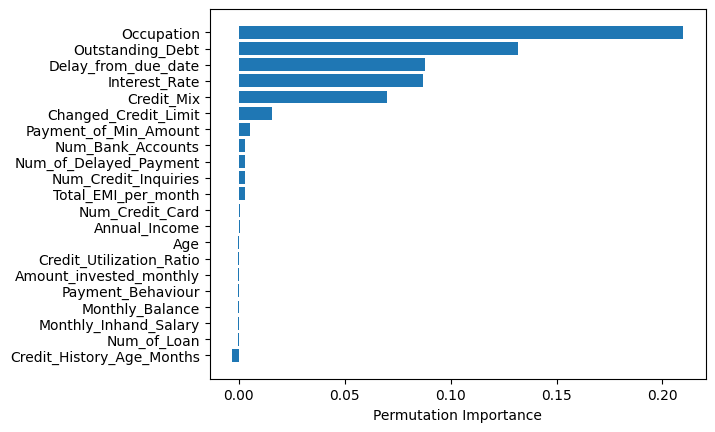

In [9]:
result = permutation_importance(best_model_optuna, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = result.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

### Оценка важности признаков после GridSearchCV

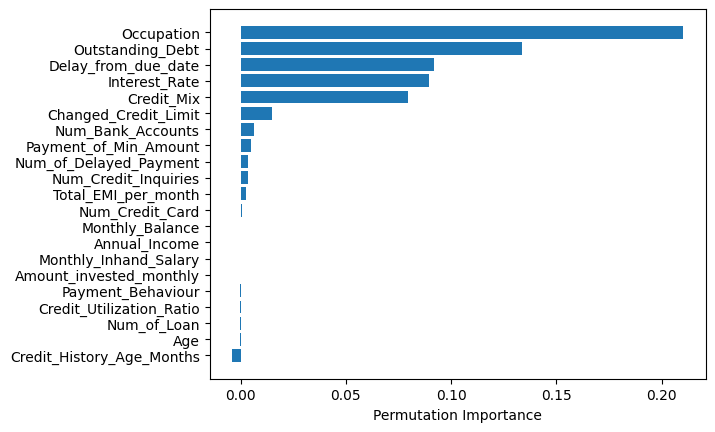

In [10]:
result = permutation_importance(best_model_cv, X_test, y_test, n_repeats=10, random_state=22)

sorted_idx = result.importances_mean.argsort()
plt.barh(X_test.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

# Анализируем полученные результаты
Можно заметить, что обе модели имеют одинаковые и не одинаковые проранжированные фичи.   
Рассмотрим первые 5 фичей.

Согласно результатам наиболее важными признаками (от обеих моделей) являются Occupation, Outstanding_Debt, Credit_Mix, Interest_Rate и Delay_from_due_date, выглядит довольно логично для задачи кредитного скоринга.
1) Occupation -> Род занятий может напрямую влиять на платежеспособность клиента. Например, люди с постоянной работой, высокой должностью или стабильным доходом более предсказуемы в плане выплат.
2) Outstanding_Debt -> Неоплаченные долг показывает финансовое состояние клиента.
3) Credit_Mix -> Скорее всего, клиенты с успешным опытом в управлении разными типами кредитов могут рассматриваться как менее рискованные (большой опыт быть должником)
4) Interest_Rate -> Высокие процентные ставки могут быть связаны с низкой кредитоспособностью клиента (например, клиенту ранее назначали высокую ставку из-за высокого риска).
5) Delay_from_due_date -> Задержки платежей тоже является показателем финансового состояния клиента.

Мое мнение: Признаки, выбранные моделью, кажутся логичными, так как они напрямую связаны с платежеспособностью клиентов и рисками невыплат.